In [3]:
import sys
import importlib as imp
if ('Jupytils' in sys.modules):
    reloaded = imp.reload(Jupytils)
else:
    import Jupytils
    

<IPython.core.display.Javascript object>

In [4]:
ff="../data/AirPassengers.csv"
df1 = LoadDataSet(ff);
df1['Month'] = pd.to_datetime(df1.Month)
df1 = df1.set_index(df1.Month)
df1 = df1.drop(['Month'], 1)
print (df1.index)
ts = df1

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01', '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01', '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'], dtype='datetime64[ns]', name='Month', length=144, freq=None)


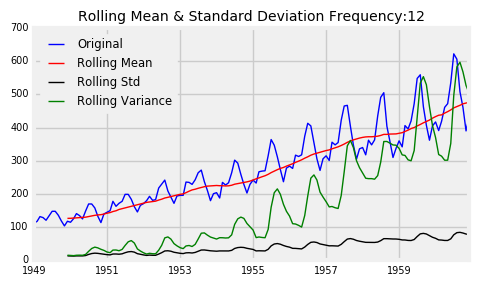

Results of Dickey-Fuller Test:
Test Statistic                  0.815
p-value                         0.992
#Lags Used                     13.000
Number of Observations Used   130.000
Critical Value (5%)            -2.884
Critical Value (1%)            -3.482
Critical Value (10%)           -2.579
dtype: float64  NON-Stationary (DF test Fails)

*** Lets try taking log ****


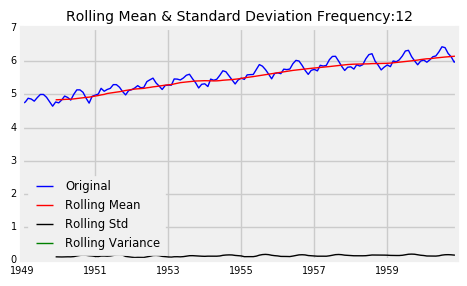

Results of Dickey-Fuller Test:
Test Statistic                 -1.717
p-value                         0.422
#Lags Used                     13.000
Number of Observations Used   130.000
Critical Value (5%)            -2.884
Critical Value (1%)            -3.482
Critical Value (10%)           -2.579
dtype: float64  NON-Stationary (DF test Fails)

**** Lets try taking moving average of log ****


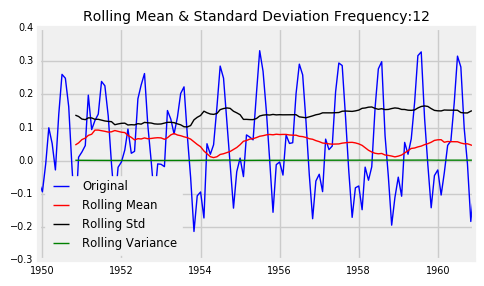

Results of Dickey-Fuller Test:
Test Statistic                 -3.163
p-value                         0.022
#Lags Used                     13.000
Number of Observations Used   119.000
Critical Value (5%)            -2.886
Critical Value (1%)            -3.487
Critical Value (10%)           -2.580
dtype: float64 Stationary

--Hmmm ...


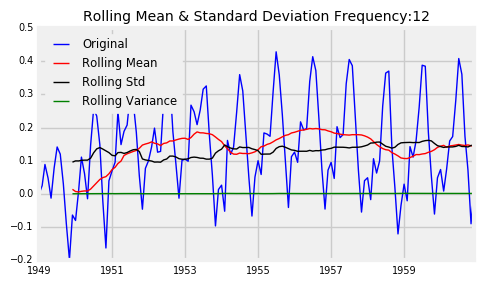

Results of Dickey-Fuller Test:
Test Statistic                 -3.601
p-value                         0.006
#Lags Used                     13.000
Number of Observations Used   130.000
Critical Value (5%)            -2.884
Critical Value (1%)            -3.482
Critical Value (10%)           -2.579
dtype: float64 Stationary

 **Seems like series is good now!!!


In [288]:
# Check for Stationarity of Data H(0) = Series is not stationary
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api 
from statsmodels.tsa.arima_model import ARIMA


def test_stationarity(timeseries, freq=12): 
    #Determing rolling statistics
    
    timeseries = timeseries.dropna()
    rolmean = pd.rolling_mean(timeseries, window=freq)
    rolstd = pd.rolling_std(timeseries, window=freq)
    rolvar = pd.rolling_var(timeseries, window=freq)

    #Plot rolling statistics:
    plt.figure(figsize=(5,3))
    plt.rc('font', size=7)
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean ')
    plt.plot(rolstd, color='black', label = 'Rolling Std ')
    plt.plot(rolvar/12, color='green', label = 'Rolling Variance')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation Frequency:' + str(freq) )
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    
    if ( len(timeseries.shape) > 1):
        dftest = adfuller(timeseries.values.ravel(), autolag='AIC')
    else:
        dftest = adfuller(timeseries, autolag='AIC')
        
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    sta = "Stationary";
    if (dftest[1] > 0.05):
        sta = " NON-Stationary (DF test Fails)"
    print (dfoutput, sta)
    
    return dftest[1]

fts = ts
f1 = test_stationarity(fts)
if ( f1 > 0.05):
    print ("\n*** Lets try taking log ****")
    fts = np.log(fts);
    f1 = test_stationarity( fts )

freq = 12 # Change this to correct frequency
if ( f1 > 0.05):
    print ("\n**** Lets try taking moving average of log ****")
    fts = ( fts - pd.rolling_mean(fts, freq)) # Make it ge
    fts.dropna(inplace=True)
    f1 = test_stationarity( fts )

if ( f1 > 0.02):
    print ("\n--Hmmm ...")
    fts = pd.ewma(np.log(ts), halflife=12) #Exponetial moving average
    f1 = test_stationarity( np.log(ts) - fts )


if ( f1 < 0.05):
    print ("\n **Seems like series is good now!!!")
    
# If it is still not stationary - try other things such as:
# fts = np.log(ts) - ts.shift(1)  # Try with various shifts
# OR try decomposing 
#
#

nobs  :  144


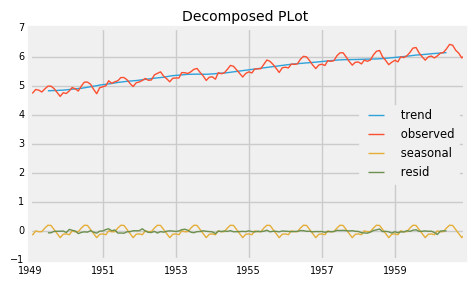

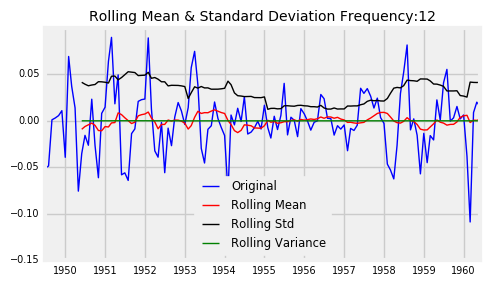

Results of Dickey-Fuller Test:
Test Statistic                 -6.332
p-value                         0.000
#Lags Used                      9.000
Number of Observations Used   122.000
Critical Value (5%)            -2.886
Critical Value (1%)            -3.485
Critical Value (10%)           -2.580
dtype: float64 Stationary


2.8850589033235044e-08

In [289]:
def plotN(dts):
    plt.figure(figsize=(5,3))
    plotted = 0;
    for k in vars(dts):
        v = getattr(dts, k);
        #print (k , type(v))
        if (not "DataFrame" in str(type(v)) ):
            print (k , " : " , v)
            continue;
        plt.plot (v, label = " " + k)
        plotted += 1
    if ( plotted > 0 ):
        plt.legend(loc='best')
        plt.title( "Decomposed PLot " )

dts = seasonal_decompose(np.log(ts) )
#plt.plot(dts)
plotN(dts)
test_stationarity(dts.resid)

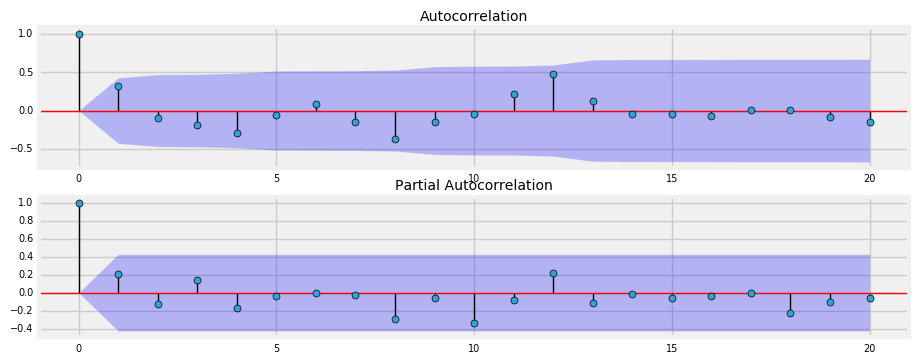

In [358]:
#ACF AND PACF plots

# Use first difference 
fts = np.log(ts) - np.log(ts).shift()
fts.dropna(inplace = True)


a = acf(fts, nlags=20)
p = pacf(fts, nlags=20)

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(211)
fig = statsmodels.graphics.tsaplots.plot_acf(a, ax=ax1)
ax2 = fig.add_subplot(212)
fig = statsmodels.graphics.tsaplots.plot_pacf(p, ax=ax2)

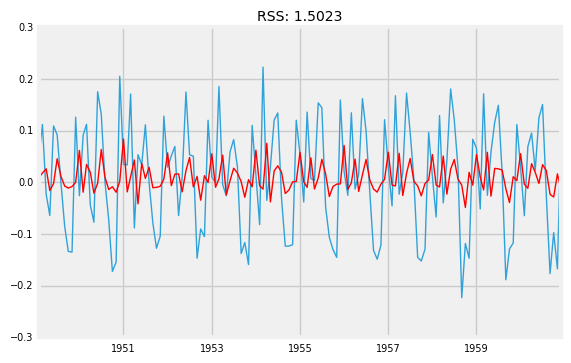

In [359]:
model = ARIMA(fts, order=(2, 0, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(fts)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum( (results_AR.fittedvalues-fts.values.ravel())**2)  );
plt.show()



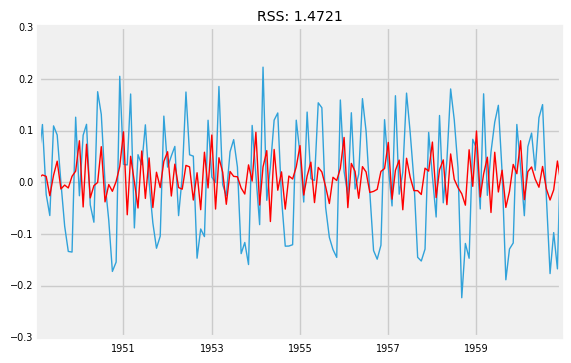

In [361]:
model = ARIMA(fts, order=(0, 0, 2))  
results_AR = model.fit(disp=-1)  
plt.plot(fts)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum( (results_AR.fittedvalues-fts.values.ravel())**2)  );


In [343]:
'RSS: %.4f'% sum((results_AR.fittedvalues-fts[1:].values.ravel())**2)

'RSS: 2.4749'

## Scaffolding for Time Series


In [ ]:
'''
This shows how ACF is computed. 
'''


def shift(x,b):
    if ( b <= 0 ):
        return x
    d = np.array(x);
    d1 = d
    d1[b:] = d[:-b]
    d1[0:b] = 0
    return d1

# One way of doing it using bare bones
x = np.arange(0,10)
xo = x - x.mean()

cors = [ np.correlate(xo,shift(xo,i))[0]  for i in range(len(x1)) ]
print (cors/cors[0] )

#-- Here is another way
cors = np.correlate(xo,xo,'full')[n-1:]
cors/cors[0]
x